# Dataset

In [ ]:
import numpy as np
import segmentation_models_pytorch as smp
import torch
from torch.utils.data import DataLoader, Subset
from dataset import HSIDataset
from torchvision.transforms import v2

path = '../../ivan/HELICoiD/HSI_Human_Brain_Database_IEEE_Access/'

dataset = HSIDataset(path)
dataset.crop_dataset()

# Segmentation Model Split
# train_indices = list(range(0, 19))
# val_indices = list(range(19, 24))
# test_indices = list(range(24, 36))

# Autoencoder Split
train_indices = list(range(0, 33))
val_indices = list(range(33, 35))
test_indices = list(range(35, 36))

trainset = Subset(dataset, train_indices)
valset = Subset(dataset, val_indices)
testset = Subset(dataset, test_indices)

trainloader = DataLoader(trainset, batch_size=2, shuffle=True)
validationloader = DataLoader(valset, batch_size=2, shuffle=False)
testloader = DataLoader(testset, batch_size=2, shuffle=False)

# Windowing

778.821
887.957


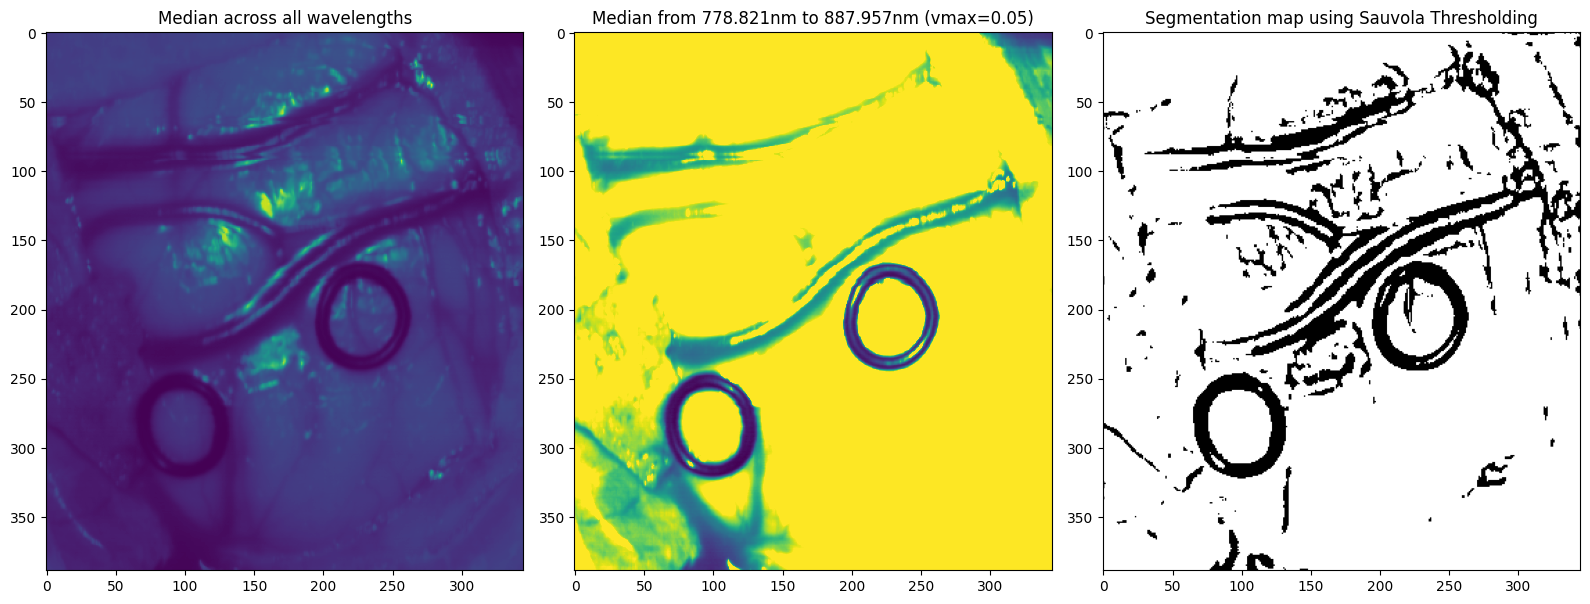

In [4]:
#patient = "012-02"
#patient = "025-02"
#patient = "015-01"
# patient = "012-01"
#patient = "016-04"
#patient = "008-01"
# patient = "020-01"
patient = "004-02"
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pickle
import glob
import pickle
from scipy.linalg import pinv
import time
from tqdm import tqdm
from skimage import filters, color, io
from matplotlib.ticker import LinearLocator
import skimage

import pickle
import matplotlib.pyplot as plt
import random
from matplotlib.colors import Normalize
from PIL import Image
from spectral import open_image
import matplotlib.cm as cm


# left=140
# right=280
#left=200
#right=201
left=520
right=670


hdr_path = path+"/{}/raw.hdr".format(patient)
img = open_image(hdr_path)
wavelength = np.array(img.metadata['wavelength']).astype(float)
print(wavelength[left])
print(wavelength[right])
# print(np.where((wavelength >= 700) & (wavelength <= 900))[0])

white_path = path+"/{}/whiteReference.hdr".format(patient)
white = open_image(white_path)
white = white.load()

dark_path = path+"/{}/darkReference.hdr".format(patient)

dark = open_image(dark_path)
dark = dark.load()

white_full = np.tile(white, (img.shape[0],1,1))
dark_full = np.tile(dark, (img.shape[0],1,1))

img_normalized = ((img.load() - dark_full) / (white_full - dark_full))
#img_normalized = ((img.load() - dark_full) / (white_full - dark_full))+0.1
img_normalized[img_normalized <= 0] = 10**-2

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))
axs[0].imshow(np.median(img_normalized,axis=2))
axs[0].set_title("Median across all wavelengths")
median_hb = (np.median(img_normalized[:,:,left:right],axis=2))
median_hb_normalized = (median_hb - np.min(median_hb))/(np.max(median_hb) - np.min(median_hb))
plt2 = axs[1].imshow(median_hb_normalized, vmax=0.05)
axs[1].set_title("Median from " + str(wavelength[left]) + "nm to " + str(wavelength[right]) + "nm (vmax=0.05)")
axs[2].imshow((median_hb_normalized > filters.threshold_sauvola(median_hb_normalized)), cmap='gray')
axs[2].set_title("Segmentation map using Sauvola Thresholding")
plt.tight_layout()
#plt.savefig(plot_dir + "segm")
#plt3 = axs[2].imshow((median_hb < 0.3)*median_hb)

# Visualize Data

/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


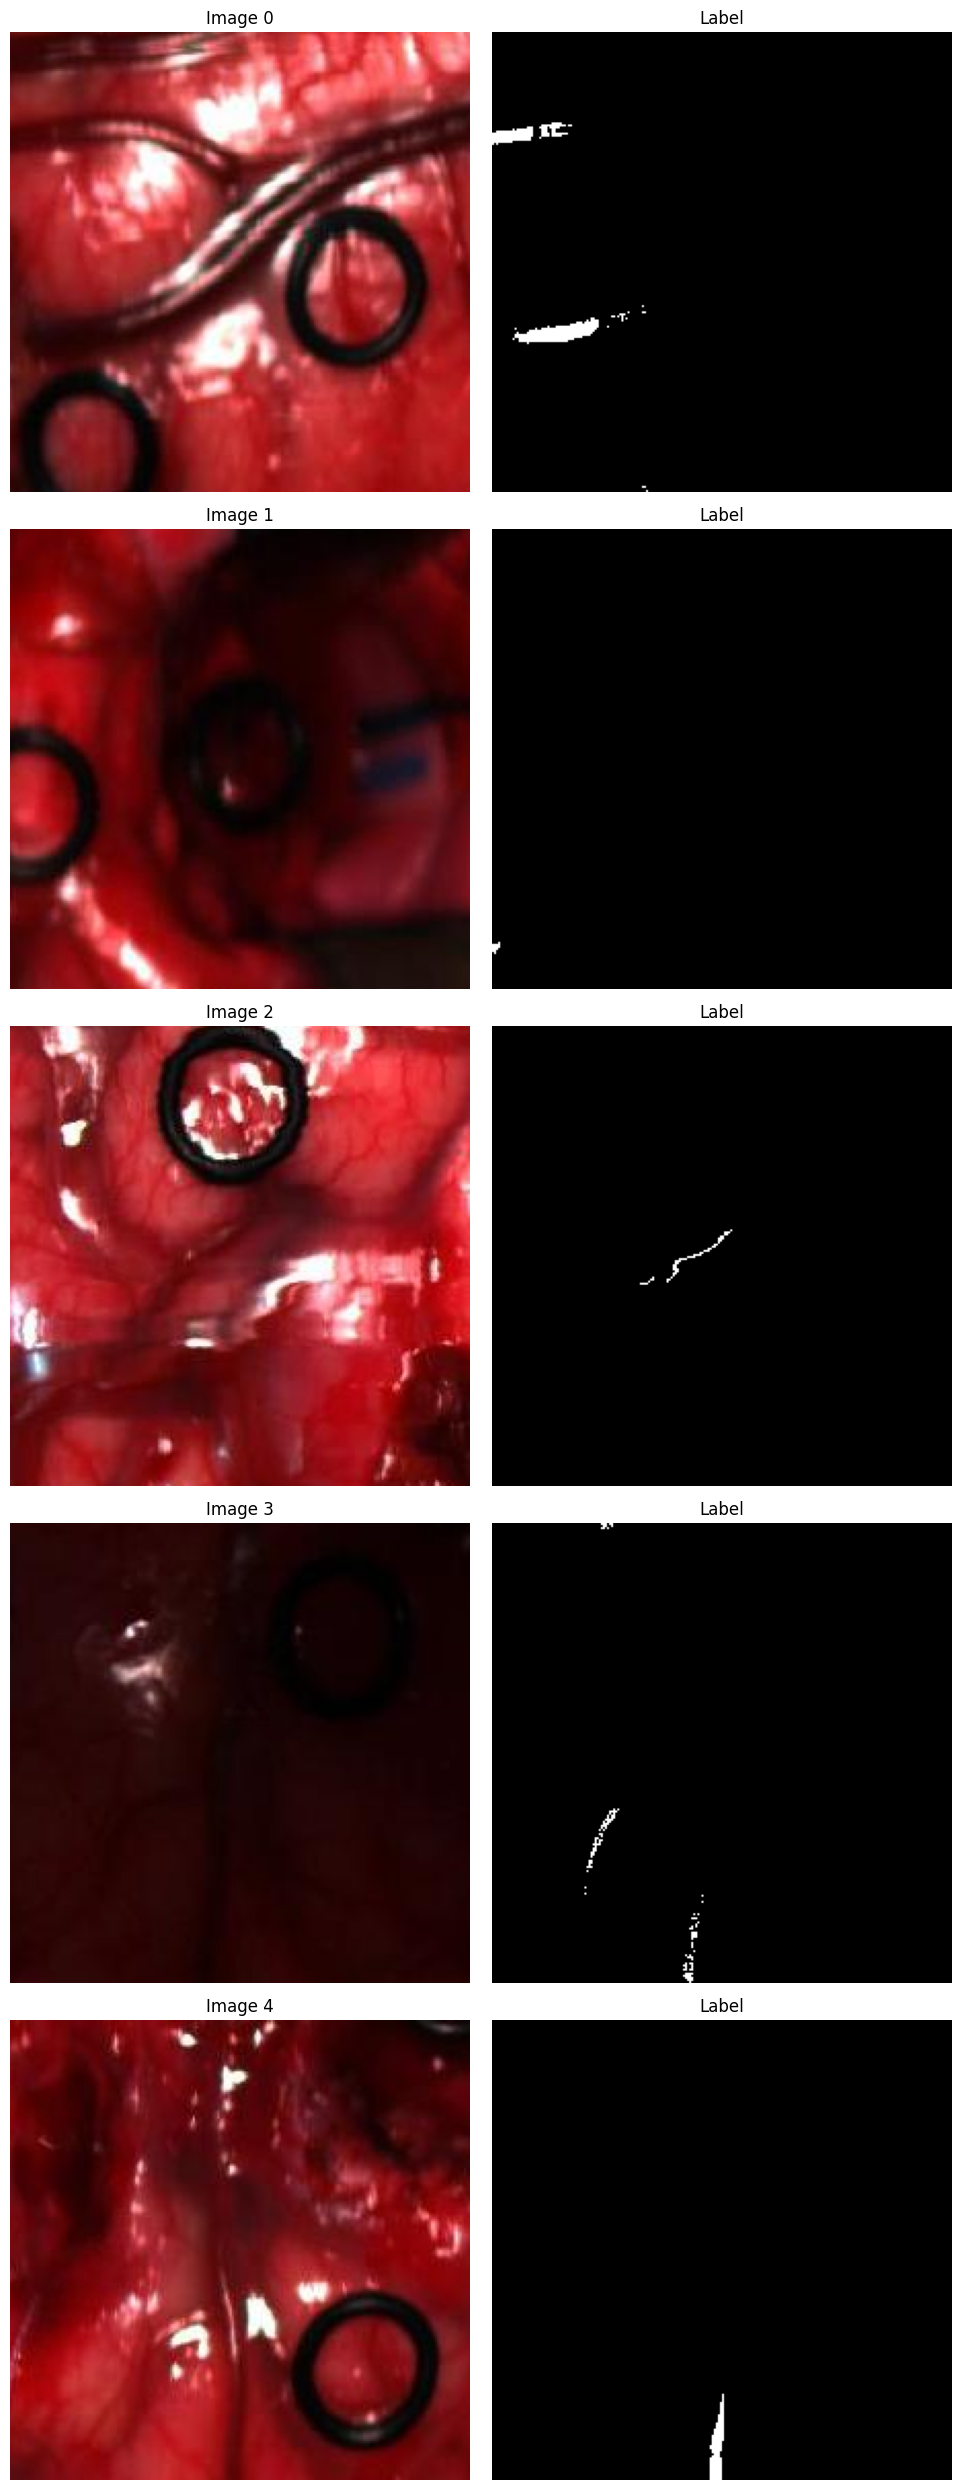

In [2]:
from dataset import create_montage
import numpy as np

create_montage(dataset, num_images=5)

# Model Initialization

In [ ]:
import segmentation_models_pytorch as smp
import torch.nn as nn
from segmentation_util import model_pipeline
import torch.nn.functional as F
from HSI_Net import HyperspectralToGrayscale, CombinedModel, ConvolutionalReducer, Unet

config = {
    'model': 'Test-model',
    'learning_rate': 0.001,
    'epochs': 10,
    'batch_size': 1,
    'optimizer': 'Adam',
    'criterion': 'BCELoss',
}

segmenter = smp.Unet('resnet34', in_channels=1, classes=1)
segmenter.load_state_dict(torch.load('./models/Unet-resnet34-DiceLoss/Unet-resnet34-DiceLoss_epoch10.pth'))
encoder = HyperspectralToGrayscale()
model = CombinedModel(encoder, segmenter)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# Training

In [ ]:
import matplotlib.pyplot as plt
from segmentation_util import model_pipeline


model, train_losses, val_losses = model_pipeline(model, trainloader=trainloader, 
                                                 validationloader=validationloader, 
                                                 testloader=testloader, criterion=criterion, 
                                                 optimizer=optimizer,project='hsi-segmentation',
                                                 model_name=config['model'],
                                                 device=device, config=config, 
                                                 batch_print=1)

# Plotting the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

In [ ]:
import torch
from HSI_Net import CombinedModel, HyperspectralToGrayscale, ConvolutionalReducer
from segmentation_util import predict, show_overlay
import segmentation_models_pytorch as smp
import cv2
import numpy as np
import matplotlib.pyplot as plt

encoder = HyperspectralToGrayscale()
segmenter = smp.Unet('resnet34', in_channels=1, classes=1)
# segmenter.load_state_dict(torch.load('./models/Unet-resnet34-DiceLoss/Unet-resnet34-DiceLoss_epoch10.pth'))
model = CombinedModel(encoder, segmenter)
model.load_state_dict(torch.load('./models/ConvLayer-Unet-resnet34/ConvLayer-Unet-resnet34_epoch10.pth'))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

show_overlay(model, testset[0], device)

# Autoencoder Approach:
## Standard Autoencoder

In [ ]:
from autoencoder import model_pipeline_autoencoder, Autoencoder
import torch.nn as nn
from torchsummary import summary

config = {
    'model': 'autoencoder-single-channel-with-normalized-cropped-data-deeper',
    'learning_rate': 0.001,
    'epochs': 10,
    'batch_size': trainloader.batch_size,
    'optimizer': 'Adam',
    'criterion': 'MSELoss',
}

autoencoder = Autoencoder(output_channels=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=config['learning_rate'])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

autoencoder, train_losses, val_losses = model_pipeline_autoencoder(autoencoder,
                                                trainloader=trainloader, 
                                                validationloader=validationloader, 
                                                criterion=criterion, 
                                                optimizer=optimizer,
                                                project='hsi-autoencoder',
                                                model_name=config['model'],
                                                device=device, 
                                                config=config, 
                                                batch_print=1)

## Variational Autoencoder

In [ ]:
from autoencoder import model_pipeline_variational_autoencoder, VariationalAutoencoder
from torchsummary import summary

config = {
    'model': 'variational-autoencoder',
    'learning_rate': 0.001,
    'epochs': 10,
    'batch_size': trainloader.batch_size,
    'optimizer': 'Adam',
    'criterion': 'vae_loss',
}

vae = VariationalAutoencoder()
optimizer = torch.optim.Adam(vae.parameters(), lr=config['learning_rate'])
device = torch.device('cuda:6' if torch.cuda.is_available() else 'cpu')

vae, train_losses, val_losses = model_pipeline_variational_autoencoder(vae,
                                                trainloader=trainloader, 
                                                validationloader=validationloader, 
                                                optimizer=optimizer,
                                                project='hsi-autoencoder',
                                                model_name=config['model'],
                                                device=device, 
                                                config=config, 
                                                batch_print=1)

# Ensemble Model Approach:

/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


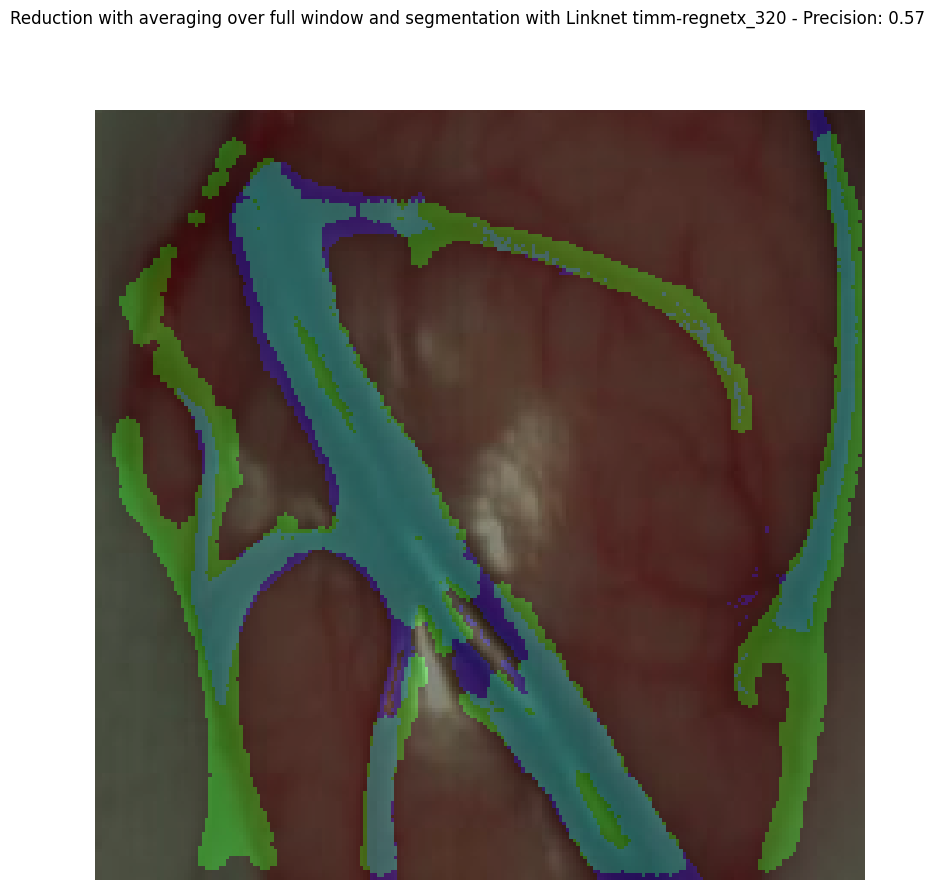

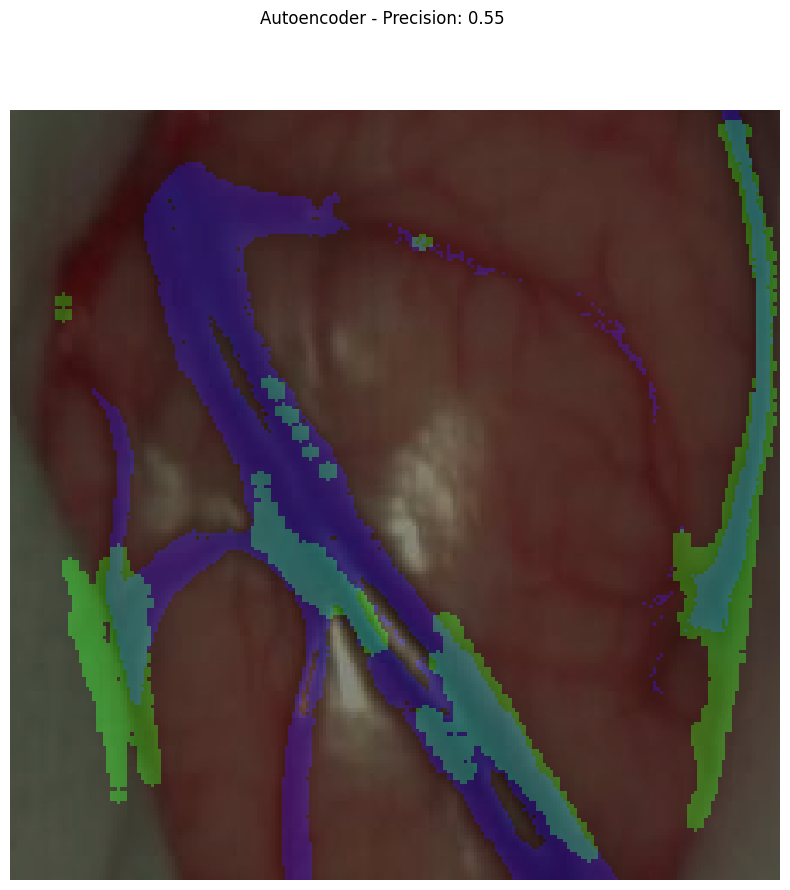

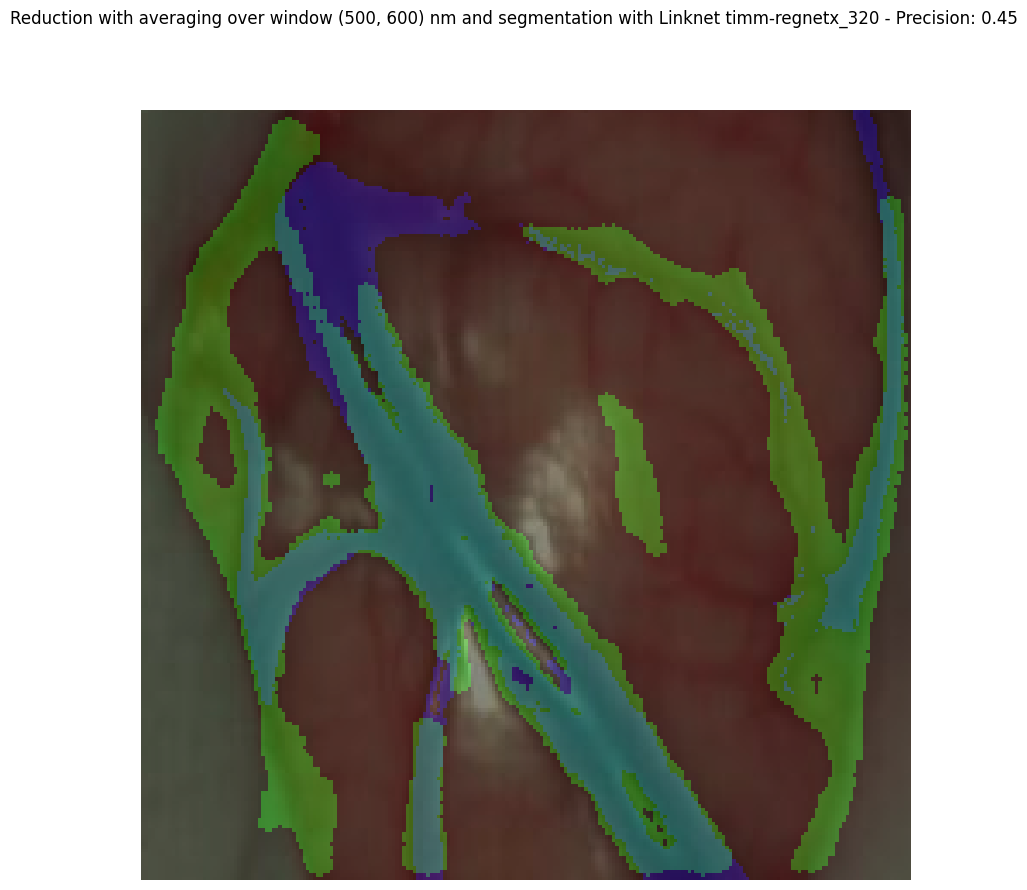

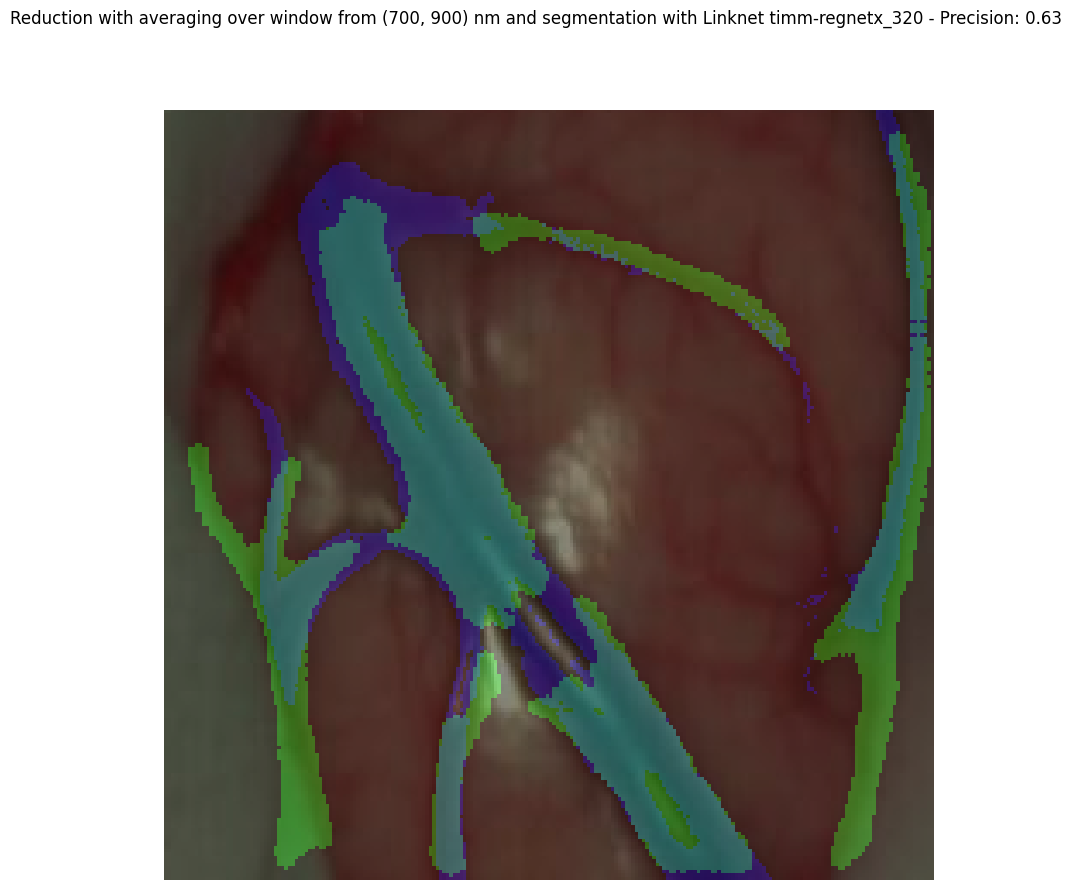

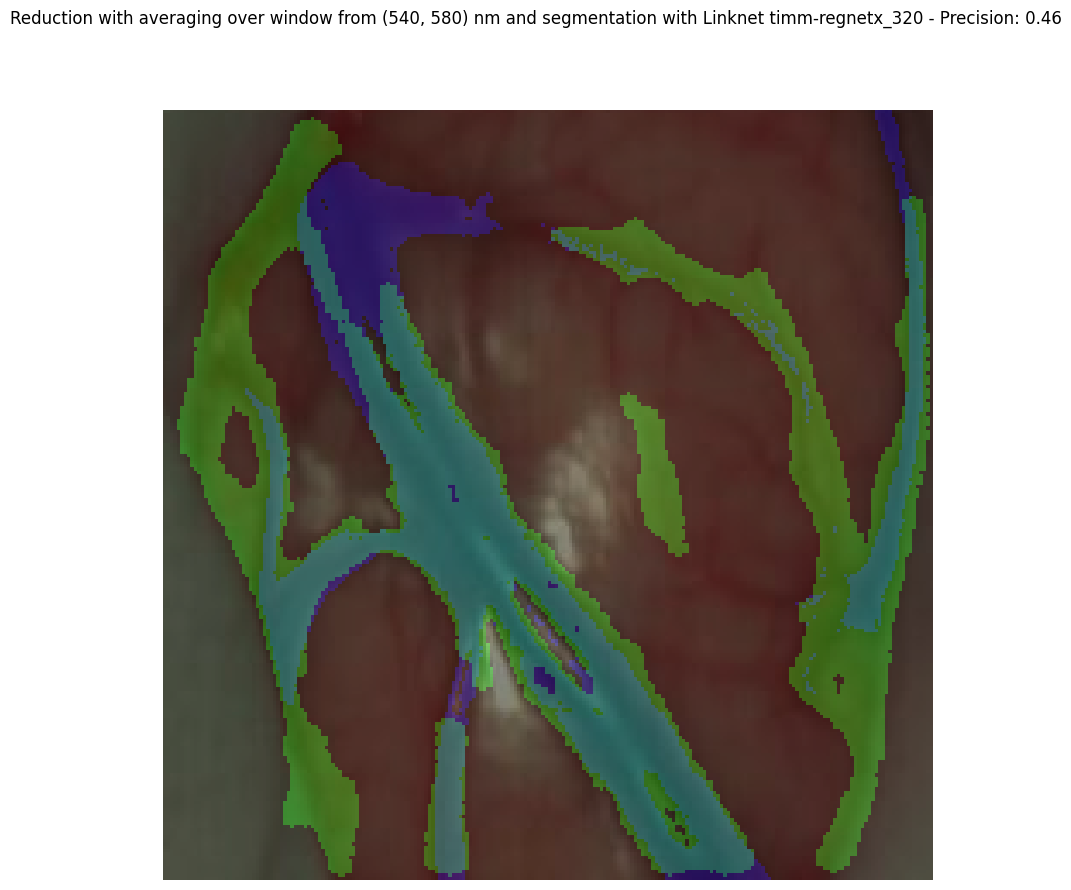

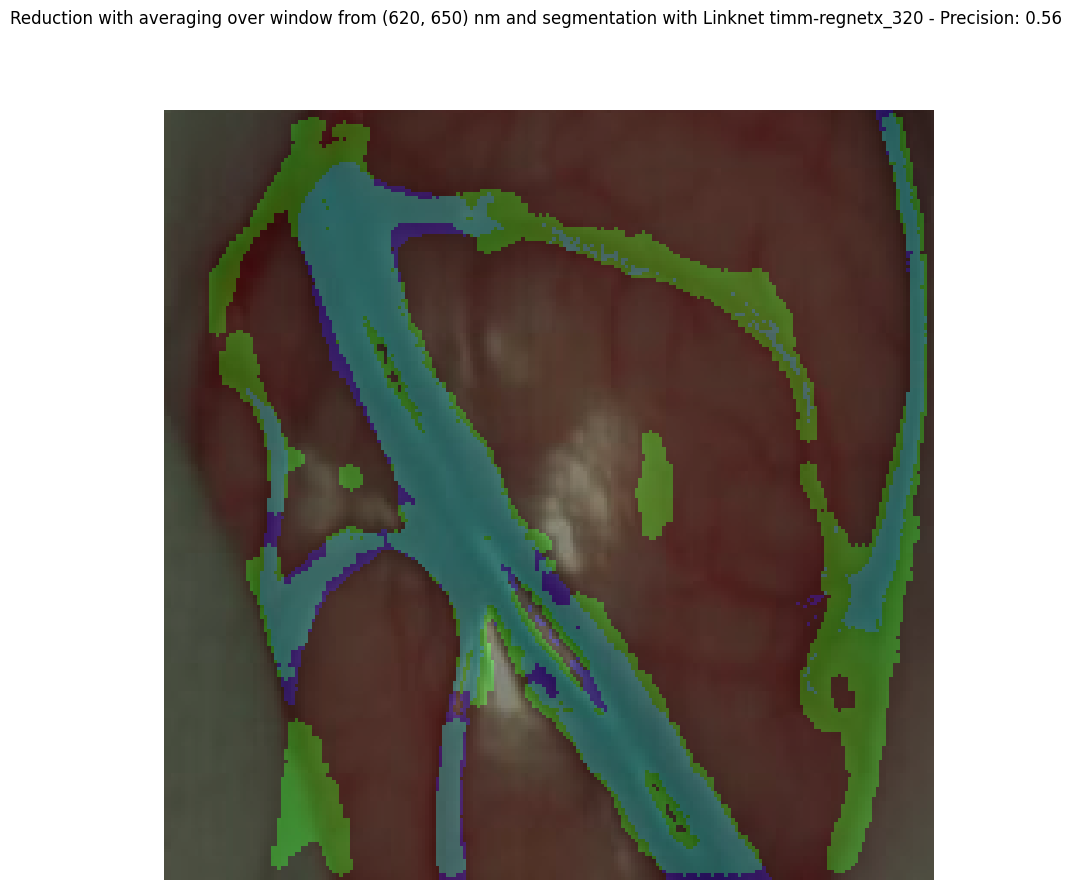

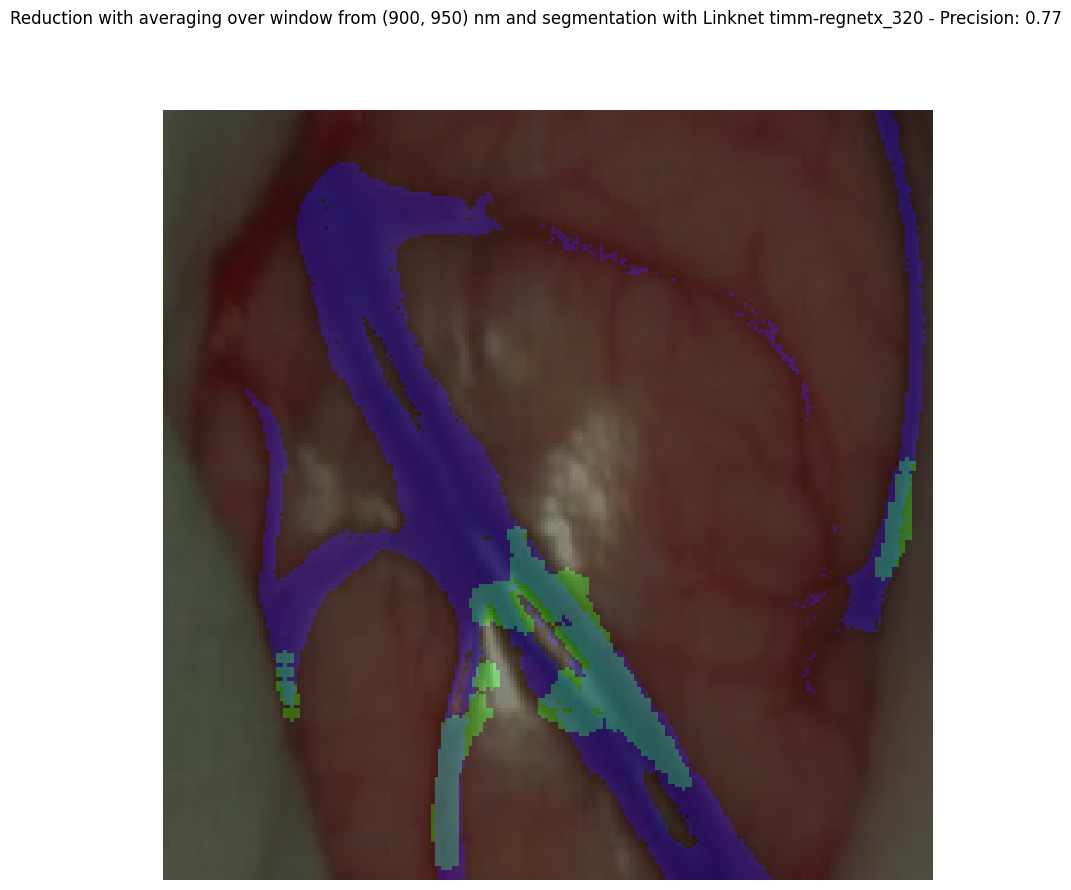

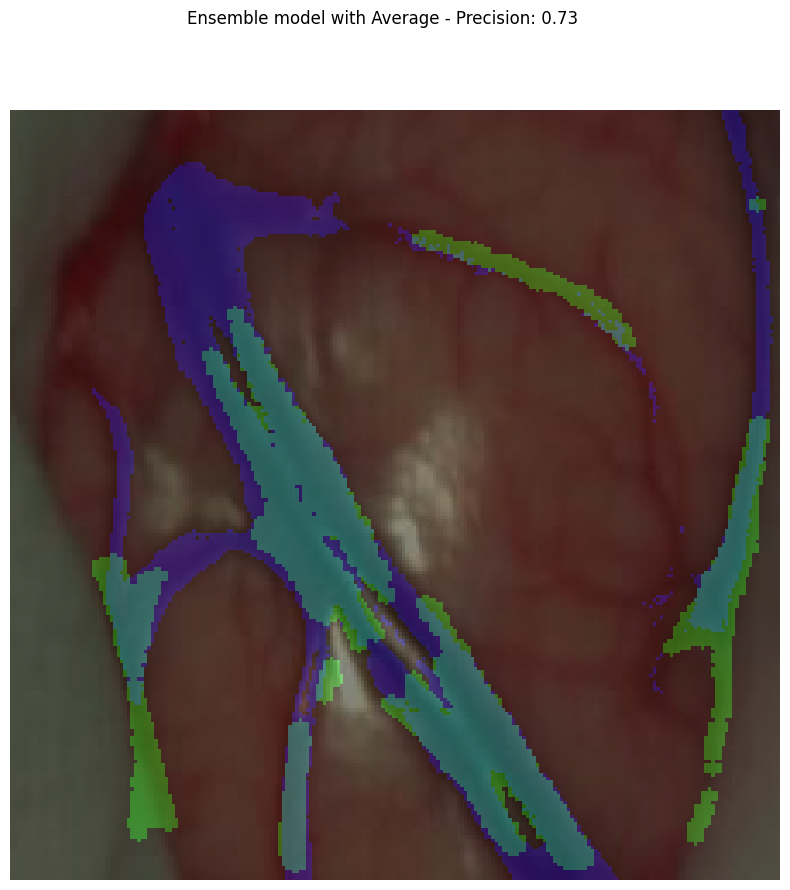

In [5]:
from HSI_Net import CombinedModel, SegmentationModelWithWindowing
from segmentation_util import predict, show_overlay, build_segmentation_model
from autoencoder import Autoencoder, DeeperAutoencoder
from ensemble_model import EnsembleModelMajorityVoting, EnsembleModelAverage, EnsembleModelAbsoluteVoting
import segmentation_models_pytorch as smp
import torch

device = ('cuda:1' if torch.cuda.is_available() else 'cpu')
data = dataset[35]

autoencoder_single_channel = Autoencoder(output_channels=1)
autoencoder_single_channel.load_state_dict(torch.load('./models/autoencoder-single-channel-with-normalized-cropped-data.pth'))
autoencoder_single_channel.to(device)
autoencoder_single_channel.eval()

encoder = 'timm-regnetx_320'
architecture = 'Linknet'

segmenter_single_channel = build_segmentation_model(encoder, architecture, device)
segmenter_single_channel.load_state_dict(torch.load('./models/{architecture}-{encoder}-512x512-augmented-with-random-crops-single-channel-focal.pth'.format(architecture=architecture, encoder=encoder)))
segmenter_single_channel.eval()

window_full = (400, 1100)
model_window_full = SegmentationModelWithWindowing(segmenter_single_channel, window=dataset.get_window_from_wavelengths(window_full))

window1 = (700, 900)
model_windowing_700to900 = SegmentationModelWithWindowing(segmenter_single_channel, window=dataset.get_window_from_wavelengths(window1))


window2 = (500, 600)
# segmenter_windowed = smp.UnetPlusPlus('resnext101_32x8d', in_channels=1, classes=1)
# segmenter_windowed.load_state_dict(torch.load('./models/UnetPlusPlus-resnext101_32x8d-512x512-augmented-with-random-crops-single-channel.pth'))
# segmenter_windowed.to(device)

model_with_windowing_500to600 = SegmentationModelWithWindowing(segmenter_single_channel, window=dataset.get_window_from_wavelengths(window2))

window3 = (540, 580)
window4 = (620, 650)
window5 = (900, 950)

model_windowing_540to580 = SegmentationModelWithWindowing(segmenter_single_channel, window=dataset.get_window_from_wavelengths(window3))
model_windowing_620to650 = SegmentationModelWithWindowing(segmenter_single_channel, window=dataset.get_window_from_wavelengths(window4))
model_windowing_900to1000 = SegmentationModelWithWindowing(segmenter_single_channel, window=dataset.get_window_from_wavelengths(window5))
model_autoencoder = CombinedModel(autoencoder_single_channel.encoder, segmenter_single_channel)

threshold = 0.6

show_overlay(model_window_full, data, device, title='Reduction with averaging over full window and segmentation with {architecture} {encoder}'.format(architecture=architecture, encoder=encoder), threshold=threshold)

show_overlay(model_autoencoder, data, device, title='Autoencoder', threshold=threshold)

show_overlay(model_with_windowing_500to600, data, device, title='Reduction with averaging over window {window2} nm and segmentation with {architecture} {encoder}'.format(window2=window2, architecture=architecture, encoder=encoder), threshold=threshold)
show_overlay(model_windowing_700to900, data, device, title='Reduction with averaging over window from {window1} nm and segmentation with {architecture} {encoder}'.format(window1=window1, architecture=architecture, encoder=encoder), threshold=threshold)
show_overlay(model_windowing_540to580, data, device, title='Reduction with averaging over window from {window3} nm and segmentation with {architecture} {encoder}'.format(window3=window3, architecture=architecture, encoder=encoder), threshold=threshold)
show_overlay(model_windowing_620to650, data, device, title='Reduction with averaging over window from {window4} nm and segmentation with {architecture} {encoder}'.format(window4=window4, architecture=architecture, encoder=encoder), threshold=threshold)
show_overlay(model_windowing_900to1000, data, device, title='Reduction with averaging over window from {window5} nm and segmentation with {architecture} {encoder}'.format(window5=window5, architecture=architecture, encoder=encoder), threshold=threshold)


model = EnsembleModelAverage([model_with_windowing_500to600, model_windowing_700to900, model_windowing_620to650, model_windowing_900to1000, model_window_full])
output = model_window_full(data[0].unsqueeze(0).to(device))

show_overlay(model, data, device, with_sigmoid=False, title='Ensemble model with Average', threshold=threshold)

## Visualization of different Thresholds

In [4]:
from HSI_Net import CombinedModel, SegmentationModelWithWindowing
from segmentation_util import predict, show_overlay, build_segmentation_model, show_interactive_overlay
from autoencoder import Autoencoder, DeeperAutoencoder
from ensemble_model import EnsembleModelMajorityVoting, EnsembleModelAverage, EnsembleModelAbsoluteVoting
import segmentation_models_pytorch as smp
from ipywidgets import FloatSlider, interact, fixed
import torch

device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
data = dataset[35]

encoder = 'timm-regnetx_320'
architecture = 'Linknet'

segmenter_single_channel = build_segmentation_model(encoder, architecture, device)
segmenter_single_channel.load_state_dict(torch.load('./models/{architecture}-{encoder}-512x512-augmented-with-random-crops-single-channel-focal.pth'.format(architecture=architecture, encoder=encoder)))
segmenter_single_channel.eval()

window = (400, 1000)
model_with_windowing = SegmentationModelWithWindowing(segmenter_single_channel, window=dataset.get_window_from_wavelengths(window))
title = 'Reduction with averaging over window {window} and segmentation with {architecture} {encoder}'.format(window=window, architecture=architecture, encoder=encoder)

show_interactive_overlay(model_with_windowing, data, device, title=title)

/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


interactive(children=(FloatSlider(value=0.5, description='Threshold:', max=1.0, step=0.01), Text(value='Reduct…

# Mixed Approach:
The approach is to leverage transfer learning on eye fundus scans which are well labeled and look kind of similar to the bloodvessels inside the brain.

We use an autoencoder and input both the hsi scan and an eye fundus scan for dimensionality reduction of the hsi scan to one channel and also learning the structure of the bloodvessels with eye fundus scans and then use the pretrained model of the eye fundus scans.

Two branches:
- Input reduced hsi scans -> Reconstruct them
- Input FIVES images -> use loss of the groundtruth labels

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset
from dataset import HSIDataset
from dataset import SegmentationDataset, SegmentationDatasetWithRandomCrops
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision.transforms import Compose, ToTensor, Grayscale, Resize
import torch
import numpy as np
import torchvision.transforms as v2
import itertools

path = '../../home/ivan/HELICoiD/HSI_Human_Brain_Database_IEEE_Access/'

dataset = HSIDataset(path)
dataset.crop_dataset()

# Autoencoder Split
train_indices = list(range(0, 32))
val_indices = list(range(32, 34))
test_indices = list(range(34, 36))

trainset_hsi = Subset(dataset, train_indices)
valset_hsi = Subset(dataset, val_indices)
testset_hsi = Subset(dataset, test_indices)

trainloader_hsi = DataLoader(trainset_hsi, batch_size=2, shuffle=True)
trainloader_hsi = itertools.cycle(trainloader_hsi)
validationloader_hsi = DataLoader(valset_hsi, batch_size=2, shuffle=False)
testloader_hsi = DataLoader(testset_hsi, batch_size=2, shuffle=False)

train_image_path = './FIVES/train/Original'
train_label_path = './FIVES/train/GroundTruth'
test_image_path = './FIVES/test/Original'
test_label_path = './FIVES/test/GroundTruth'

np.random.seed(42)

# Define transformations for images
image_transform = Compose([
    Grayscale(num_output_channels=1),  # Convert the image to grayscale
    Resize((512, 512)),                # Resize images to 512x512
    ToTensor(),                         # Convert the image to a PyTorch tensor
    # Normalize(mean=[0.3728, 0.1666, 0.0678], std=[0.1924, 0.0956, 0.0395])
    # Normalize(mean=[0.2147], std=[0.1163])   # Normalize the grayscale image
])

# Define transformations for labels, if needed
label_transform = Compose([
    Resize((512, 512)),  # Resize labels to 512x512
    ToTensor()           # Convert label to a tensor
])

dataset = SegmentationDataset(
    train_image_path, 
    train_label_path, 
    image_transform, 
    label_transform,
)

testset = SegmentationDataset(
    test_image_path, 
    test_label_path, 
    image_transform, 
    label_transform
)

# Prepare DataLoader
dataset, _ = random_split(dataset, [105, len(dataset) - 105])
train_size, val_size = int(0.9 * len(dataset)), int(0.1 * len(dataset) + 1)
train_indices = np.random.choice(len(dataset), train_size, replace=False)
val_indices = np.setdiff1d(np.arange(len(dataset)), train_indices)

train_dataset_fundus = Subset(dataset, train_indices)
val_dataset_fundus = Subset(dataset, val_indices)


print(f'Number of samples in the training set: {len(train_dataset_fundus)}, validation set: {len(val_dataset_fundus)}')
print(f'Number of samples in the test set: {len(testset)}')

trainloader_fundus = DataLoader(train_dataset_fundus, batch_size=4, shuffle=True, num_workers=8)
validationloader_fundus = DataLoader(val_dataset_fundus, batch_size=4, shuffle=False, num_workers=8)
testloader_fundus = DataLoader(testset, batch_size=4, shuffle=False, num_workers=8)

print(len(trainloader_fundus), len(validationloader_fundus), len(testloader_fundus))

Number of samples in the training set: 94, validation set: 11
Number of samples in the test set: 200
24 3 50


In [ ]:
import wandb

def train_and_validate(encoder, segmenter, trainloader_hsi, trainloader_fundus, validationloader_hsi, validationloader_fundus, criterion_hsi, criterion_fundus, optimizer_encoder, optimizer_fundus, epochs=10, model_name=None, device='cuda', batch_print=10):
    """
    Function to train and validate
    Parameters
        :param segmenter: segmenter to train and validate
        :param loss_criterion: Loss Criterion_fundus to minimize
        :param optimizer_fundus: Optimizer_fundus for computing gradients
        :param epochs: Number of epochs (default=25)
        :param model_name: model file name (default=None)
    Returns
        train_losses, val_losses: List of losses per epoch
    """
    train_losses, val_losses = [], []
    min_val_loss = np.inf
    
    for epoch in range(epochs):
        segmenter.train()
        encoder.train()
        segmenter.to(device)
        encoder.to(device)
        running_loss = 0.0
        train_loss = 0.0
        for i, (hsi_data, fundus_data) in enumerate(zip(trainloader_hsi, trainloader_fundus)):
            fundus_img, labels_labels = fundus_data[0].to(device), fundus_data[1].to(device).float()
            outputs_fundus = segmenter(fundus_img)
            optimizer_fundus.zero_grad()
            loss_fundus = criterion_fundus(outputs_fundus, labels_labels)
            loss_fundus.backward()
            optimizer_fundus.step()

            hsi_img = hsi_data[0].to(device)
            reduced_hsi = encoder(hsi_img)
            outputs_hsi = segmenter(reduced_hsi)
            optimizer_encoder.zero_grad()
            optimizer_fundus.zero_grad()
            loss_hsi = criterion_hsi(outputs_hsi, reduced_hsi)
            loss_hsi.backward()
            optimizer_encoder.step()
            optimizer_fundus.step()

            running_loss += (loss_fundus.item() + loss_hsi.item()) / 2
            train_loss += (loss_fundus.item() + loss_hsi.item()) / 2

            if (i + 1) % batch_print == 0:  # Adjust the condition based on your preference
                print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / batch_print:.4f}')
                running_loss = 0.0  # Reset running loss after printing
                
        # Calculate and print the average loss per epoch
        train_loss = train_loss / (len(trainloader_fundus))
        train_losses.append(train_loss)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}')
        # wandb.log({"epoch":epoch+1, "train/loss": train_loss}, step=epoch+1)
        
        # Validation phase
        segmenter.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for i, (hsi_data, fundus_data) in enumerate(zip(validationloader_hsi, validationloader_fundus)):
                inputs, labels = fundus_data[0].to(device), fundus_data[1].to(device).float()
                outputs = segmenter(inputs)
                loss_fundus = criterion_fundus(outputs, labels)

                hsi_img = hsi_data[0].to(device)
                reduced_hsi = encoder(hsi_img)
                outputs_hsi = segmenter(reduced_hsi)
                loss_hsi = criterion_hsi(outputs_hsi, reduced_hsi)

                val_running_loss += (loss_fundus.item() + loss_hsi.item())/2
        
        val_loss = val_running_loss / (len(validationloader_fundus))
        val_losses.append(val_loss)

        if model_name:
            if val_loss < min_val_loss:
                min_val_loss = val_loss
                torch.save(segmenter.state_dict(), f'./models/{model_name}_segmenter.pth')
                torch.save(encoder.state_dict(), f'./models/{model_name}_encoder.pth')
                # model_artifact = wandb.Artifact(f"{model_name}", type="model")
                # model_artifact.add_file(f'./models/{model_name}.pth')
                # wandb.log_artifact(model_artifact)

        print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.4f}')
        # wandb.log({"epoch":epoch+1, "validation/loss": val_loss}, step=epoch+1)
    
    return train_losses, val_losses



In [ ]:
import segmentation_models_pytorch as smp
from autoencoder import Autoencoder
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt

segmenter = smp.Unet('timm-resnest101e', in_channels=1, classes=1)
segmenter.load_state_dict(torch.load('./models/Unet-timm-resnest101e-512x512-augmented-with-random-crops-normalized_epoch10.pth'))
autoencoder = Autoencoder(output_channels=1)
autoencoder.load_state_dict(torch.load('./models/autoencoder-single-channel-with-cropped-data.pth'))

config = {
    'model': 'DualModel_encoder_with_mse',
    'learning_rate': 0.001,
    'epochs': 10,
    'batch_size': trainloader_fundus.batch_size,
    'optimizer': 'Adam',
    'criterion': 'MSELoss, DiceLoss',
}

autoencoder = Autoencoder(output_channels=1)

criterion_hsi = nn.MSELoss()
criterion_fundus = smp.losses.DiceLoss(mode='binary')

optimizer_fundus = torch.optim.Adam(segmenter.parameters(), lr=config['learning_rate'])
optimizer_encoder = torch.optim.Adam(autoencoder.encoder.parameters(), lr=config['learning_rate'])

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_losses, val_losses = train_and_validate(encoder=autoencoder.encoder, 
                   segmenter=segmenter, 
                   trainloader_hsi=trainloader_hsi, 
                   trainloader_fundus=trainloader_fundus, 
                   validationloader_hsi=validationloader_hsi, 
                   validationloader_fundus=validationloader_fundus,
                   criterion_hsi=criterion_hsi,
                   criterion_fundus=criterion_fundus,
                   optimizer_encoder=optimizer_encoder,
                   optimizer_fundus=optimizer_fundus,
                   epochs=10,
                   model_name=config['model'],
                   device=device,
                   batch_print=1)

# Plotting the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()


In [ ]:
from HSI_Net import CombinedModel
from segmentation_util import predict, show_overlay
import cv2

# def show_overlay(model, data, device):
#     prediction = predict(model, data[0], device)
#     image = data[1].cpu().numpy().squeeze()
#     image = np.stack([image, image, image], axis=-1)
#     overlay = np.zeros_like(image)
#     overlay[prediction.cpu().numpy().squeeze(0) == 1] = [0, 255, 0]
#     combined = cv2.addWeighted(image, 0.7, overlay, 0.3, 0)
    
#     plt.figure(figsize=(10, 10))
#     plt.imshow(combined, cmap='gray')
#     plt.axis('off')  # Turn off axis numbers and ticks
#     plt.show()

segmenter = smp.Unet('timm-resnest101e', in_channels=1, classes=1)
segmenter.load_state_dict(torch.load('./models/DualModel_encoder_with_mse_segmenter.pth'))
autoencoder = Autoencoder(output_channels=1)
autoencoder.encoder.load_state_dict(torch.load('./models/DualModel_encoder_with_mse_encoder.pth'))

model = CombinedModel(autoencoder.encoder, segmenter)
show_overlay(model, trainset_hsi[22], device)

# Evaluation

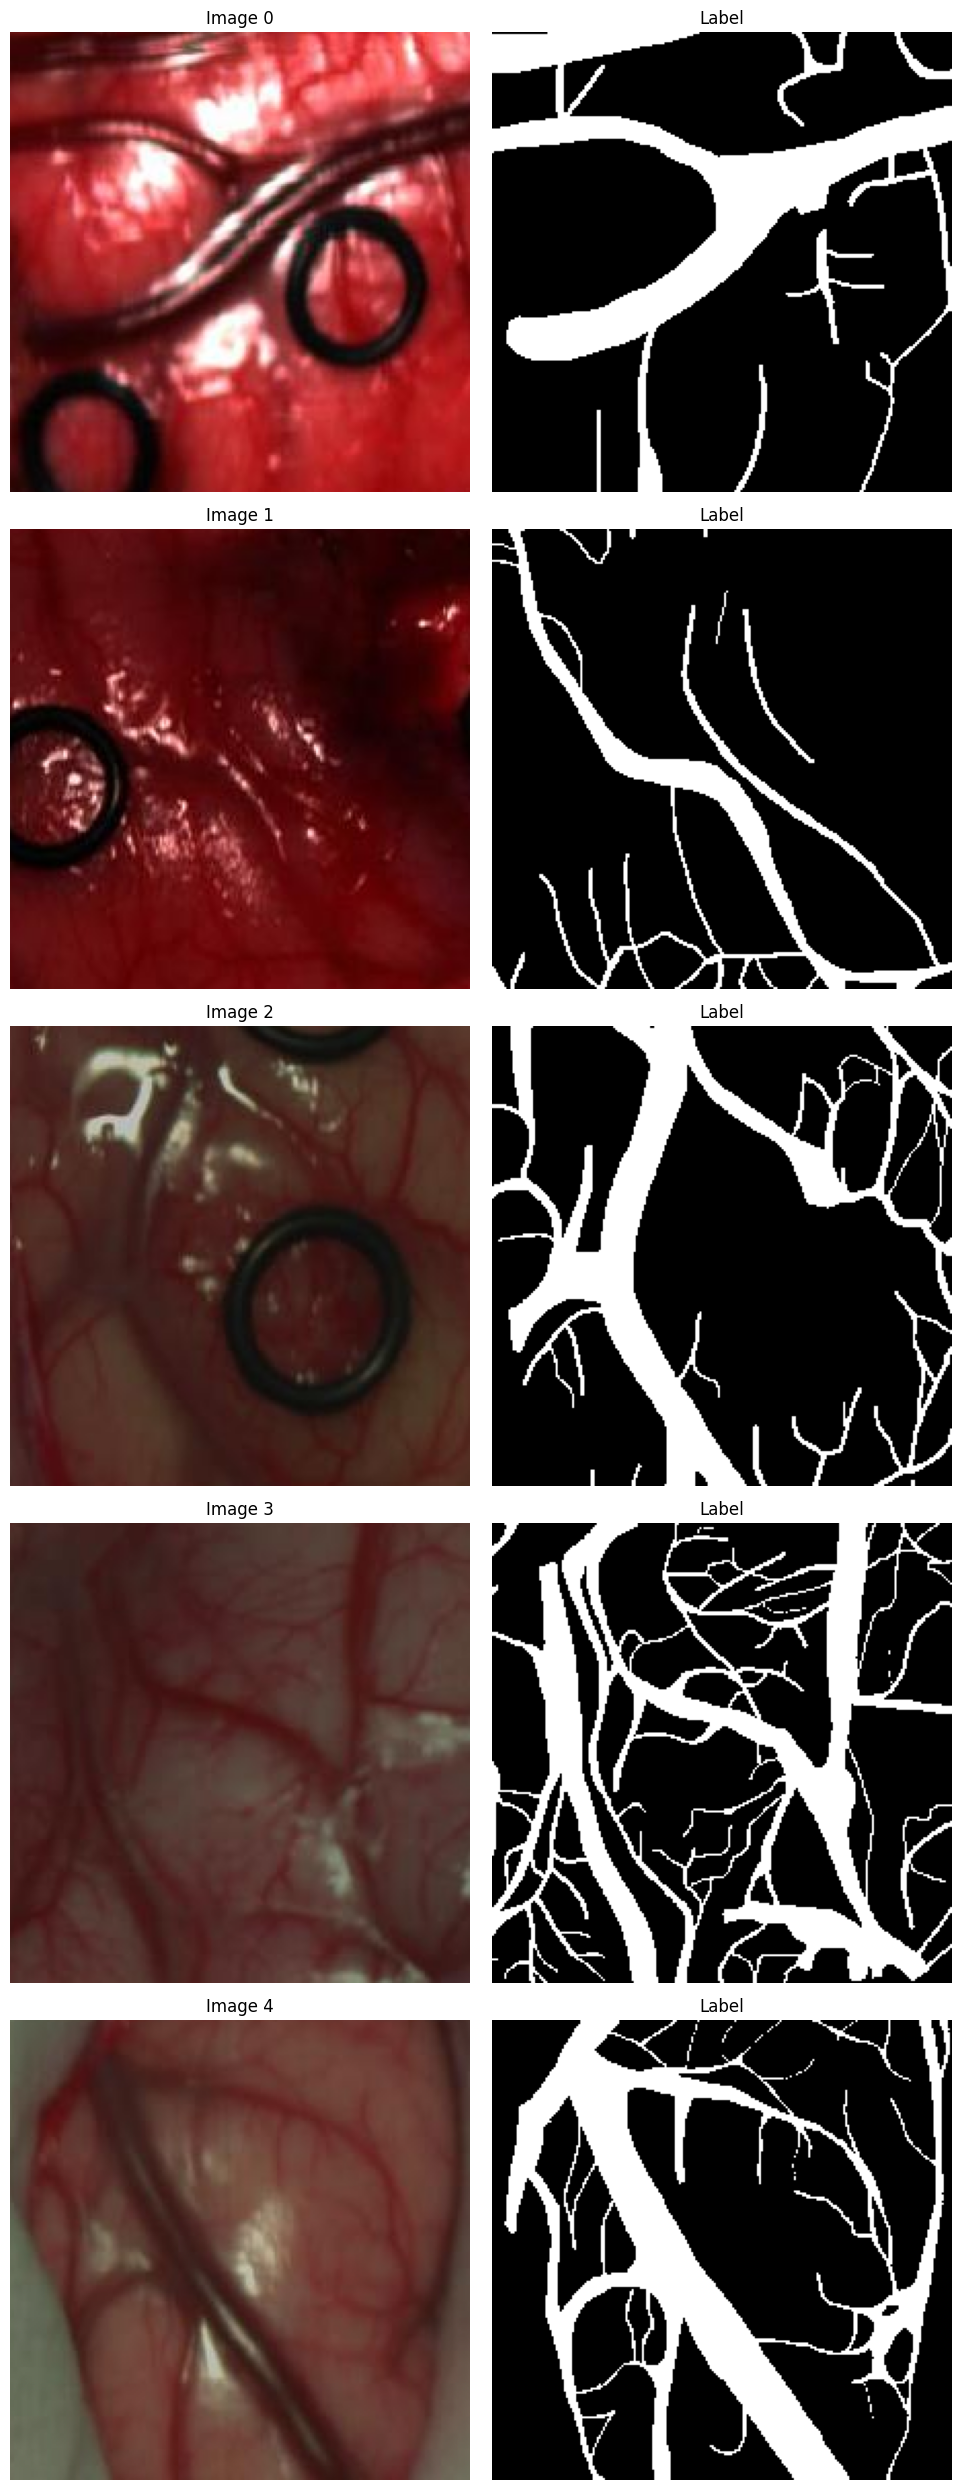

In [ ]:
from dataset import HSIDataset, create_montage
import matplotlib.pyplot as plt
import numpy as np

path = './data/helicoid_with_labels'
evaluation_dataset = HSIDataset(path, with_gt=True, window=(500,600))
evaluation_dataset.crop_dataset()
create_montage(evaluation_dataset, num_images=5)

## Ensemble Model

In [3]:
from HSI_Net import CombinedModel, SegmentationModelWithWindowing
from segmentation_util import build_segmentation_model, show_interactive_overlay
from ensemble_model import EnsembleModelMajorityVoting, EnsembleModelAverage, EnsembleModelAbsoluteVoting
import segmentation_models_pytorch as smp
from ipywidgets import FloatSlider, interact, fixed
import torch

device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
data = evaluation_dataset[0]

encoder = 'timm-regnetx_320'
architecture = 'Linknet'

segmenter_single_channel = build_segmentation_model(encoder, architecture, device)
segmenter_single_channel.load_state_dict(torch.load('./models/{architecture}-{encoder}-512x512-augmented-with-random-crops-single-channel-focal.pth'.format(architecture=architecture, encoder=encoder)))
segmenter_single_channel.eval()

window1 = (400, 500)
window2 = (500, 600)
window3 = (600, 700)
window4 = (700, 800)
window5 = (800, 900)
window6 = (900, 1000)
window_full = (400, 1100)


model_windowing_400to500 = SegmentationModelWithWindowing(segmenter_single_channel, window=evaluation_dataset.get_window_from_wavelengths(window1))
model_with_windowing_500to600 = SegmentationModelWithWindowing(segmenter_single_channel, window=evaluation_dataset.get_window_from_wavelengths(window2))
model_windowing_600to700 = SegmentationModelWithWindowing(segmenter_single_channel, window=evaluation_dataset.get_window_from_wavelengths(window3))
model_windowing_700to800 = SegmentationModelWithWindowing(segmenter_single_channel, window=evaluation_dataset.get_window_from_wavelengths(window4))
model_windowing_800to900 = SegmentationModelWithWindowing(segmenter_single_channel, window=evaluation_dataset.get_window_from_wavelengths(window5))
model_windowing_900to1000 = SegmentationModelWithWindowing(segmenter_single_channel, window=evaluation_dataset.get_window_from_wavelengths(window6))
model_window_full = SegmentationModelWithWindowing(segmenter_single_channel, window=evaluation_dataset.get_window_from_wavelengths(window_full))

model = EnsembleModelAverage([model_windowing_400to500, model_with_windowing_500to600, model_windowing_600to700, model_windowing_700to800, model_windowing_900to1000, model_window_full])
title = 'Ensemble Model with averaging and segmentation with {architecture} {encoder}'.format(architecture=architecture, encoder=encoder)

show_interactive_overlay(model, data, device, title=title)

interactive(children=(FloatSlider(value=0.5, description='Threshold:', max=1.0, step=0.01), Text(value='Ensemb…

## Without Domain Adaptation

In [ ]:
from HSI_Net import CombinedModel, SegmentationModelWithWindowing
from segmentation_util import build_segmentation_model, show_interactive_overlay
from ensemble_model import EnsembleModelMajorityVoting, EnsembleModelAverage, EnsembleModelAbsoluteVoting
import segmentation_models_pytorch as smp
from ipywidgets import FloatSlider, interact, fixed
from dataset import HSIDataset
import torch

path = './data/helicoid_with_labels'
evaluation_dataset = HSIDataset(path, with_gt=True, window=(300,1100))
evaluation_dataset.crop_dataset()

device = ('cuda:2' if torch.cuda.is_available() else 'cpu')
data = evaluation_dataset[4]

encoder = 'resnet50'
architecture = 'Unet'

segmenter_single_channel = build_segmentation_model(encoder, architecture, device)
segmenter_single_channel.load_state_dict(torch.load('./models/{architecture}-{encoder}-2048x2048-grayscale.pth'.format(architecture=architecture, encoder=encoder)))
segmenter_single_channel.eval()

title = 'Ensemble Model with averaging and segmentation with {architecture} {encoder}'.format(architecture=architecture, encoder=encoder)

show_interactive_overlay(segmenter_single_channel, data, device, title=title)

interactive(children=(FloatSlider(value=0.5, description='Threshold:', max=1.0, step=0.01), Text(value='Ensemb…

## Domain Adaptation

In [ ]:
from HSI_Net import ModelWithDomainAdaptation, DomainClassifierConv
from segmentation_util import build_segmentation_model, show_interactive_overlay
from dataset import HSIDataset
import segmentation_models_pytorch as smp
from ipywidgets import FloatSlider, interact, fixed
import torch

path = './data/helicoid_with_labels'
evaluation_dataset = HSIDataset(path, with_gt=True, window=(400, 1100))
evaluation_dataset.crop_dataset()
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
data = evaluation_dataset[2]

encoder = 'timm-regnetx_320'
architecture = 'Linknet'

domainClassifier = DomainClassifierConv()
segmenter_single_channel = build_segmentation_model(encoder, architecture, device)
model = ModelWithDomainAdaptation(segmenter_single_channel, 1.0, domainClassifier)
model.load_state_dict(torch.load('./models/HSI_Net_DA.pth'))
model.eval()
title = 'Model with Domain Adaptation and segmentation with {architecture} {encoder}'.format(architecture=architecture, encoder=encoder)

show_interactive_overlay(model, data, device, title=title)

/home/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/home/tim_ivan/idp/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


interactive(children=(FloatSlider(value=0.5, description='Threshold:', max=1.0, step=0.01), Text(value='Model …